In [1]:
%pip install -q pennylane
%pip install -q qnetvo

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pennylane as qml
from pennylane import numpy as np
import qnetvo

In [3]:
qutrit_0 = np.array([1, 0, 0])  # |00⟩
qutrit_1 = np.array([0, 1, 0])  # |01⟩
qutrit_2 = np.array([0, 0, 1])  # |10⟩
qutrits = [qutrit_0, qutrit_1, qutrit_2]

def create_bs_state(i, j):
    if i != j:
        return (qutrits[i] + qutrits[j]) / np.sqrt(2)
    else:
        return qutrits[i]
    
def create_ba_state(k, l):
    return (qutrits[k] - qutrits[l]) / np.sqrt(2)


Bs = []
for i in range(3):
    for j in range(i, 3):
        Bs.append(create_bs_state(i, j))

Ba = []
for k in range(3):
    for l in range(k+1, 3):
        Ba.append(create_ba_state(k, l))

print("Bs States:")
for state in Bs:
    print(state)

print("\nBa States:")
for state in Ba:
    print(state)

Bs States:
[1 0 0]
[0.70710678 0.70710678 0.        ]
[0.70710678 0.         0.70710678]
[0 1 0]
[0.         0.70710678 0.70710678]
[0 0 1]

Ba States:
[ 0.70710678 -0.70710678  0.        ]
[ 0.70710678  0.         -0.70710678]
[ 0.          0.70710678 -0.70710678]


In [4]:
def tensor_product(state1, state2):
    return np.kron(state1, state2)

# p is the probability parameter of the Werner state, it should be between 0 and 1
p = 1  

coeff_bs = np.sqrt(p / 6)
coeff_ba = np.sqrt((1 - p) / 3)

phi_w_p = np.zeros(9)

for state in Bs:
    phi_w_p += coeff_bs * tensor_product(state, state)

for state in Ba:
    phi_w_p += coeff_ba * tensor_product(state, state)
    
# Normalize the state vector <- TODO: Should there be this normalization step? Otimes?
phi_w_p /= np.linalg.norm(phi_w_p)

print("The state vector of the purification of the Werner state is:")
print(phi_w_p)

The state vector of the purification of the Werner state is:
[0.54433105 0.13608276 0.13608276 0.13608276 0.54433105 0.13608276
 0.13608276 0.13608276 0.54433105]


In [40]:
# We have a 9D qutrit werner state that we encode into 4 qubits. But where into the 4 qubits does it go?
# Would it be important that 1 qutrit takes 2 qubits with no crossover, how can we be sure this is happening?
# Might we need to trace out each qutrit and prepare an amplitude embedding of each half into 2 qubits?


def prepare_w(settings, wires):
    qml.AmplitudeEmbedding(features=phi_w_p, wires=wires[0:5], pad_with=0.)

entanglement_prep_node = qnetvo.PrepareNode(
    wires=[2,3,4,5], ansatz_fn=prepare_w
)

In [41]:
def prepare_bs(settings, wires):
    # initalize quantum state from |0...0>
    qml.Hadamard(wires=wires[0])
    qml.CNOT(wires=wires)
    
input_prep_node = qnetvo.PrepareNode(
    wires=[0,1], ansatz_fn=prepare_bs
)

In [54]:
def cc_sender_circ(settings, wires):
    qml.ArbitraryUnitary(settings, wires=wires[0:3])

    b0 = qml.measure(wires[0])
    b1 = qml.measure(wires[1])
    b2 = qml.measure(wires[2])

    return [b0, b1, b2]

cc_sender_node = qnetvo.CCSenderNode(wires=[1,2,3], cc_wires_out=[0,1,2], ansatz_fn=cc_sender_circ, num_settings=63)

In [97]:
def cc_receiver_circ(settings, wires, cc_wires):
    qml.cond((cc_wires[0] == 0) & (cc_wires[1] == 0) & (cc_wires[2] == 0), qml.ArbitraryUnitary)(settings[0:15], wires=wires[0:2])
    qml.cond((cc_wires[0] == 0) & (cc_wires[1] == 0) & (cc_wires[2] == 1), qml.ArbitraryUnitary)(settings[15:30], wires=wires[0:2])
    qml.cond((cc_wires[0] == 0) & (cc_wires[1] == 1) & (cc_wires[2] == 0), qml.ArbitraryUnitary)(settings[30:45], wires=wires[0:2])
    qml.cond((cc_wires[0] == 0) & (cc_wires[1] == 1) & (cc_wires[2] == 1), qml.ArbitraryUnitary)(settings[45:60], wires=wires[0:2])
    qml.cond((cc_wires[0] == 1) & (cc_wires[1] == 0) & (cc_wires[2] == 0), qml.ArbitraryUnitary)(settings[60:75], wires=wires[0:2])
    qml.cond((cc_wires[0] == 1) & (cc_wires[1] == 0) & (cc_wires[2] == 1), qml.ArbitraryUnitary)(settings[75:90], wires=wires[0:2])
    qml.cond((cc_wires[0] == 1) & (cc_wires[1] == 1) & (cc_wires[2] == 0), qml.ArbitraryUnitary)(settings[90:105], wires=wires[0:2])
    qml.cond((cc_wires[0] == 1) & (cc_wires[1] == 1) & (cc_wires[2] == 1), qml.ArbitraryUnitary)(settings[105:120], wires=wires[0:2])


cc_receiver_node = qnetvo.CCReceiverNode(wires=[4,5], cc_wires_in=[0,1,2], ansatz_fn=cc_receiver_circ, num_settings=120)

In [98]:
teleportation_ansatz = qnetvo.NetworkAnsatz(
    [entanglement_prep_node], [input_prep_node], [cc_sender_node], [cc_receiver_node]
)

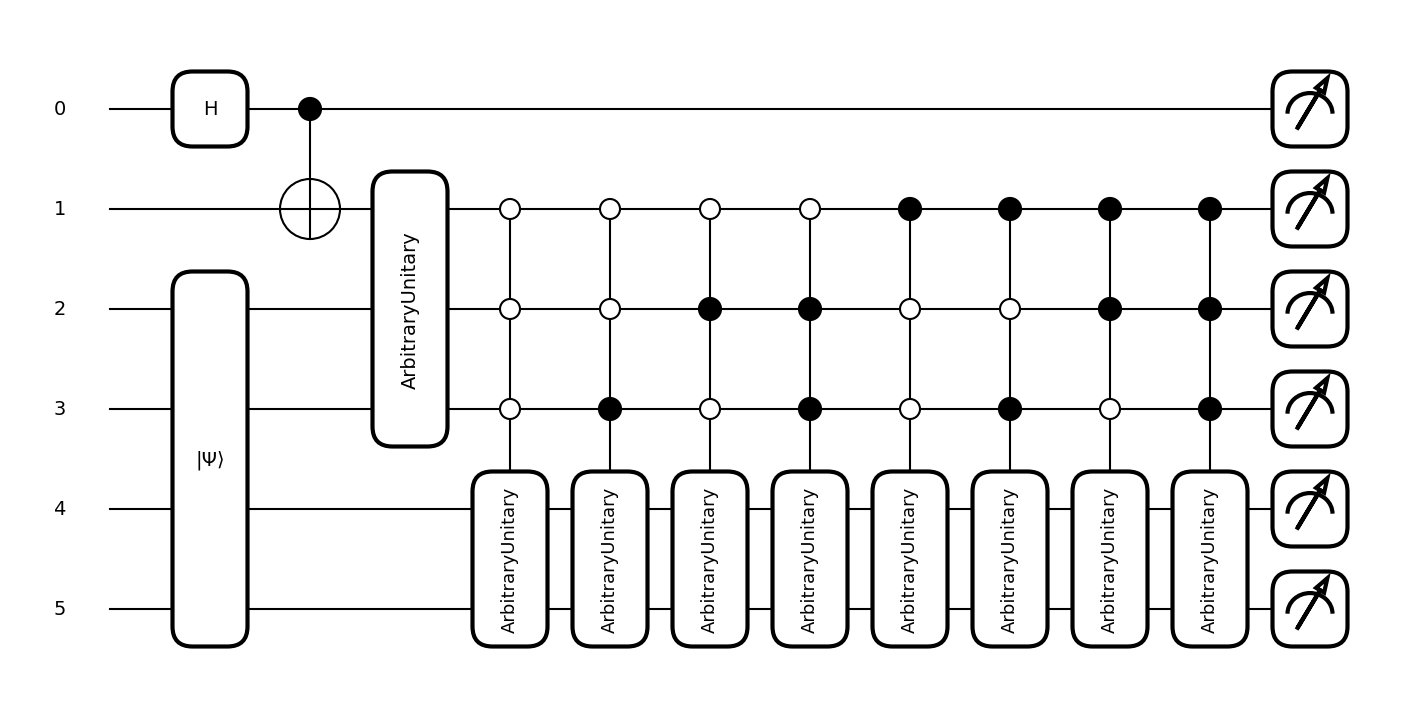

In [99]:
@qml.qnode(qml.device("default.qubit", wires=[0,1,2,3,4,5]))
def draw_circ():
    teleportation_ansatz.fn(teleportation_ansatz.zero_network_settings())

    return qml.probs(wires=[0,1,2,3,4,5])

qml.draw_mpl(draw_circ)();